In [1]:
import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import uniform, norm

In [2]:
class Robot(IdealRobot): ###### noiseメソッドは省略で
        
    def __init__(self, pose, agent=None, sensor=None, color="black", \
                           noise_prob=0.1, noise_stderr=math.pi/60, bias_rates=(0.1,0.1), \
                           stuck_prob = 0.0, stuck_max_time = 3.0, kidnapped_prob = 0.0, \
                           kidnapped_range_x = (-5.0,5.0), kidnapped_range_y = (-5.0,5.0)):  #追加
        
        super().__init__(pose, agent, sensor, color)
        self.noise_prob = noise_prob
        self.noise_stderr = noise_stderr
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rates[0]) 
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rates[1])
        self.stuck_prob = stuck_prob                                  #ここから追加
        self.stuck_max_time = stuck_max_time
        self.kidnapped_prob = kidnapped_prob
        self.kidnapped_loc_x = kidnapped_range_x[0]
        self.kidnapped_scale_x = kidnapped_range_x[1] - kidnapped_range_x[0]
        self.kidnapped_loc_y = kidnapped_range_y[0]
        self.kidnapped_scale_y = kidnapped_range_y[1] - kidnapped_range_y[0]
        
        self.stuck_time = 0.0
    
    def noise(self):
        t_noise = 0.0
        
        if uniform.rvs() < self.noise_prob:   
            t_noise = norm.rvs(scale=self.noise_stderr) 

        return np.array([0.0, 0.0, t_noise]) 
    
    def stuck(self, nu, omega, time_interval):
        if self.stuck_time <= 0.0:
            if uniform.rvs() < self.stuck_prob:
                self.stuck_time = uniform.rvs(scale=self.stuck_max_time)
            else:
                return nu, omega
            
        self.stuck_time -= time_interval
        return 0.0, uniform.rvs(scale=omega)
    
    def kidnapped_pose(self):
            x = uniform.rvs(loc=self.kidnapped_loc_x, scale=self.kidnapped_scale_x)
            y = uniform.rvs(loc=self.kidnapped_loc_y, scale=self.kidnapped_scale_y)
            t = uniform.rvs(loc=-math.pi, scale=2*math.pi)
            return np.array([x, y, t]).T
        
    def one_step(self, time_interval):
        if not self.agent: return
        nu, omega = self.agent.decision()
        nu *= self.bias_rate_nu
        if self.stuck(time_interval):   #追加 
            nu = 0.0                                #追加
            
        omega *= self.bias_rate_omega
        self.pose = self.func_state_transition(nu, omega, time_interval, self.pose) + self.noise()
        
        if uniform.rvs() < self.kidnapped_prob:
            self.pose = self.kidnapped_pose()
        
        if self.sensor: self.sensor.data(self.pose)

<IPython.core.display.Javascript object>


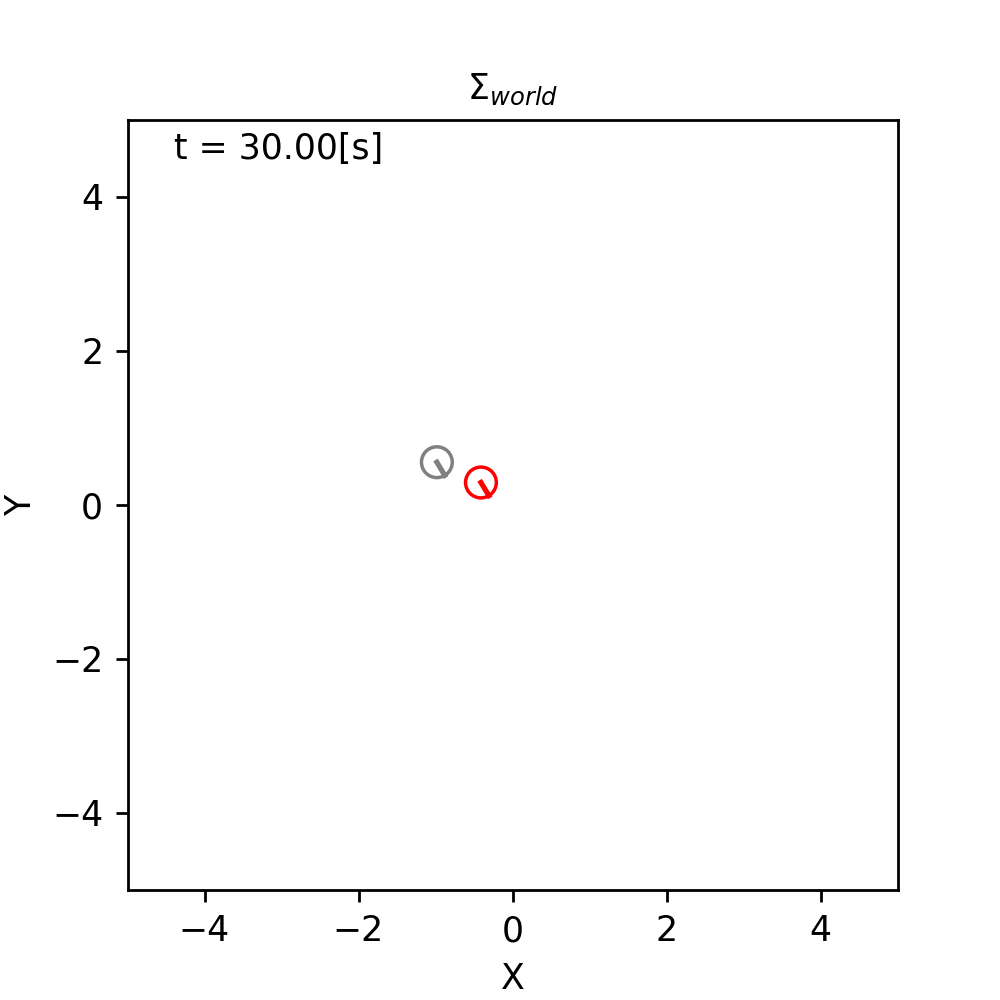

In [3]:
import copy  ###compare_nobias_bias###

world = World(30.1, 0.1) 

circling = Agent(0.2, 10.0/180*math.pi)    
nobias_robot = IdealRobot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="gray")
world.append(nobias_robot)
biased_robot = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, 
                           color="red", noise_prob=0.0 , bias_rates=(0.0,0.0), stuck_prob = 0.01)
world.append(biased_robot)

world.draw()